2nd Implementation

In [ ]:
# Check NumPy version
import numpy as np
print(f"Current NumPy version: {np.__version__}")

# If NumPy 2.x is installed, downgrade to 1.24.3
if np.__version__.startswith('2.'):
    print("Downgrading NumPy to version 1.24.3 for compatibility with Surprise...")
    !pip install numpy==1.24.3
    print("\nPlease restart the runtime now (Runtime > Restart runtime)")
    print("After restarting, run all cells from the beginning")


Current NumPy version: 2.0.2
Downgrading NumPy to version 1.24.3 for compatibility with Surprise...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.7 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but yo


Please restart the runtime now (Runtime > Restart runtime)
After restarting, run all cells from the beginning


In [ ]:
# Install required packages
!pip install scikit-surprise

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, precision_score, recall_score, ndcg_score
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithMeans
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse, mae

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463306 sha256=4dd1567e3a4b6d946dfaf3b13e1276092b426b6bc28aa6b736245c8aaeb1dd9c
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
# Create data directory
!mkdir -p data

# Download the MovieLens 100K dataset
!wget -O data/ml-100k.zip https://files.grouplens.org/datasets/movielens/ml-100k.zip

# Extract the dataset
!unzip -q data/ml-100k.zip -d data

# Define file paths
data_dir = 'data/ml-100k/'
ratings_file = os.path.join(data_dir, 'u.data' )
movies_file = os.path.join(data_dir, 'u.item')
users_file = os.path.join(data_dir, 'u.user')
genre_file = os.path.join(data_dir, 'u.genre')

# Load ratings data
# Format: user id | item id | rating | timestamp
ratings_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_file, sep='\t', names=ratings_columns, encoding='latin-1')

# Load movie data
# Format: movie id | movie title | release date | video release date | IMDb URL | genres
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
# Add genre columns
genre_data = pd.read_csv(genre_file, sep='|', names=['genre', 'genre_id'], encoding='latin-1')
genres = list(genre_data['genre'])
movie_columns.extend(genres)

# Load movie data with a different approach due to the complex format
movies = pd.read_csv(movies_file, sep='|', names=movie_columns, encoding='latin-1')

# Load user data
# Format: user id | age | gender | occupation | zip code
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(users_file, sep='|', names=user_columns, encoding='latin-1')

print("Dataset loaded successfully!")


--2025-05-29 17:15:34--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘data/ml-100k.zip’

data/ml-100k.zip    100%[===================>]   4.70M  12.3MB/s    in 0.4s    

2025-05-29 17:15:35 (12.3 MB/s) - ‘data/ml-100k.zip’ saved [4924029/4924029]

Dataset loaded successfully!


In [ ]:
# Basic information about the dataset
print("\n--- Dataset Overview ---")
print(f"Number of ratings: {len(ratings)}")
print(f"Number of unique users: {ratings['user_id'].nunique()}")
print(f"Number of unique movies: {ratings['movie_id'].nunique()}")
print(f"Rating range: {ratings['rating'].min()} to {ratings['rating'].max()}")

# Display the first few rows of each dataframe
print("\n--- Ratings Data Sample ---")
print(ratings.head())

print("\n--- Movies Data Sample ---")
print(movies[['movie_id', 'title', 'release_date']].head())

print("\n--- Users Data Sample ---")
print(users.head())

# Extract year from movie title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')
movies['title'] = movies['title'].str.replace(r' \(\d{4}\)', '', regex=True)

# Create a user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
print("\n--- User-Item Matrix Shape ---")
print(f"Shape: {user_item_matrix.shape}")
print(f"Density: {user_item_matrix.count().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.4f}")

# Create a genre feature matrix for content-based filtering
genre_cols = [col for col in movies.columns if col in genres]
movies_genres = movies[['movie_id', 'title'] + genre_cols]

# Create a text description for each movie based on its genres
movies['genre_list'] = movies[genre_cols].apply(lambda x: ' '.join([genre for genre, has_genre in zip(genre_cols, x) if has_genre == 1]), axis=1)
print("\n--- Movies with Genre Lists ---")
print(movies[['movie_id', 'title', 'genre_list']].head())

# Split data into training and testing sets (80% train, 20% test)
np.random.seed(42)
train_indices = np.random.rand(len(ratings)) < 0.8
train_data = ratings[train_indices]
test_data = ratings[~train_indices]

print(f"\nTraining set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

# Save preprocessed data for later use
train_data.to_csv('data/train_data.csv', index=False)
test_data.to_csv('data/test_data.csv', index=False)
movies.to_csv('data/processed_movies.csv', index=False)



--- Dataset Overview ---
Number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682
Rating range: 1 to 5

--- Ratings Data Sample ---
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

--- Movies Data Sample ---
   movie_id              title release_date
0         1   Toy Story (1995)  01-Jan-1995
1         2   GoldenEye (1995)  01-Jan-1995
2         3  Four Rooms (1995)  01-Jan-1995
3         4  Get Shorty (1995)  01-Jan-1995
4         5     Copycat (1995)  01-Jan-1995

--- Users Data Sample ---
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

--- User-Item Ma

2. Collaborative Filtering Implementation
2.1 User-Based Collaborative Filtering

In [ ]:
def user_based_cf(train_data, movies_df, user_id, n_neighbors=20, n_recommendations=10):
    """
    Generate movie recommendations using user-based collaborative filtering.

    Parameters:
    -----------
    train_data : pandas.DataFrame
        DataFrame containing user ratings for training
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    user_id : int
        User ID for whom to generate recommendations
    n_neighbors : int, optional (default=20)
        Number of similar users to consider
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Create user-item matrix
    user_item_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

    # Find similar users using k-nearest neighbors
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(user_item_matrix)

    # Get the user's ratings
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in the dataset.")
        return pd.DataFrame()

    user_index = user_item_matrix.index.get_loc(user_id)
    user_ratings = user_item_matrix.iloc[user_index].values.reshape(1, -1)

    # Find similar users
    distances, indices = model_knn.kneighbors(user_ratings, n_neighbors=n_neighbors+1)
    similar_users = user_item_matrix.iloc[indices[0][1:]]  # Exclude the user itself

    # Get movies that the user hasn't rated
    user_rated_movies = set(train_data[train_data['user_id'] == user_id]['movie_id'])
    all_movies = set(movies_df['movie_id'])
    unrated_movies = all_movies - user_rated_movies

    # Calculate predicted ratings for unrated movies
    recommendations = []
    for movie_id in unrated_movies:
        if movie_id not in user_item_matrix.columns:
            continue

        # Get ratings of similar users for this movie
        movie_ratings = similar_users[movie_id]

        # Skip if no similar user has rated this movie
        if movie_ratings.sum() == 0:
            continue

        # Calculate weighted average rating
        weighted_rating = (movie_ratings * (1 - distances[0][1:])).sum() / (1 - distances[0][1:]).sum()

        recommendations.append((movie_id, weighted_rating))

    # Sort recommendations by predicted rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_recommendations = recommendations[:n_recommendations]

    # Create DataFrame with recommendations
    rec_df = pd.DataFrame(top_recommendations, columns=['movie_id', 'predicted_rating'])
    rec_df = rec_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

    return rec_df[['movie_id', 'title', 'predicted_rating']]

# Test user-based collaborative filtering for a sample user
sample_user_id = 1
user_cf_recommendations = user_based_cf(train_data, movies, sample_user_id)
print(f"User-Based CF Recommendations for User {sample_user_id}:")
print(user_cf_recommendations)


User-Based CF Recommendations for User 1:
   movie_id                                              title  predicted_rating
0       181                                 Return of the Jedi          3.461654
1       474  Dr. Strangelove or: How I Learned to Stop Worr...          3.448063
2       433                                           Heathers          3.401179
3       228                       Star Trek: The Wrath of Khan          3.392204
4       204                                 Back to the Future          3.300821
5        11                                      Seven (Se7en)          3.198471
6       174                            Raiders of the Lost Ark          3.195587
7       191                                            Amadeus          3.176825
8        98                          Silence of the Lambs, The          3.110049
9       655                                        Stand by Me          3.107639


2.2 Item-Based Collaborative Filtering


In [ ]:
def item_based_cf(train_data, movies_df, user_id, n_recommendations=10):
    """
    Generate movie recommendations using item-based collaborative filtering.

    Parameters:
    -----------
    train_data : pandas.DataFrame
        DataFrame containing user ratings for training
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    user_id : int
        User ID for whom to generate recommendations
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Create user-item matrix
    user_item_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

    # Create item-item matrix (transpose of user-item matrix)
    item_item_matrix = user_item_matrix.T

    # Calculate item-item similarity matrix using cosine similarity
    item_similarity = cosine_similarity(item_item_matrix)

    # Convert to DataFrame for easier manipulation
    item_similarity_df = pd.DataFrame(item_similarity, index=item_item_matrix.index, columns=item_item_matrix.index)

    # Get the user's ratings
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in the dataset.")
        return pd.DataFrame()

    user_ratings = train_data[train_data['user_id'] == user_id]

    # Get movies that the user hasn't rated
    user_rated_movies = set(user_ratings['movie_id'])
    all_movies = set(movies_df['movie_id'])
    unrated_movies = all_movies - user_rated_movies

    # Calculate predicted ratings for unrated movies
    recommendations = []
    for movie_id in unrated_movies:
        if movie_id not in item_similarity_df.index:
            continue

        # Calculate weighted rating based on similar items the user has rated
        weighted_sum = 0
        similarity_sum = 0

        for rated_movie_id, rating in zip(user_ratings['movie_id'], user_ratings['rating']):
            if rated_movie_id not in item_similarity_df.index:
                continue

            # Get similarity between current movie and rated movie
            similarity = item_similarity_df.loc[movie_id, rated_movie_id]

            # Only consider positive similarities
            if similarity > 0:
                weighted_sum += similarity * rating
                similarity_sum += similarity

        # Calculate predicted rating if we have similarities
        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
            recommendations.append((movie_id, predicted_rating))

    # Sort recommendations by predicted rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_recommendations = recommendations[:n_recommendations]

    # Create DataFrame with recommendations
    rec_df = pd.DataFrame(top_recommendations, columns=['movie_id', 'predicted_rating'])
    rec_df = rec_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

    return rec_df[['movie_id', 'title', 'predicted_rating']]

# Test item-based collaborative filtering for a sample user
sample_user_id = 1
item_cf_recommendations = item_based_cf(train_data, movies, sample_user_id)
print(f"Item-Based CF Recommendations for User {sample_user_id}:")
print(item_cf_recommendations)


Item-Based CF Recommendations for User 1:
   movie_id                               title  predicted_rating
0      1156                               Cyclo          4.495049
1       994  Last Time I Committed Suicide, The          4.344899
2      1618                    King of New York          4.338997
3      1512     World of Apu, The (Apur Sansar)          4.308975
4      1593                  Death in Brunswick          4.226143
5      1656                         Little City          4.217149
6      1104      C'est arrivé près de chez vous          4.215397
7      1674                          Mamma Roma          4.211596
8      1558                           Aparajito          4.153260
9      1323    Wooden Man's Bride, The (Wu Kui)          4.136326


2.3 Matrix Factorization (SVD)


In [ ]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))
train_surprise = Dataset.load_from_df(train_data[['user_id', 'movie_id', 'rating']], reader)
trainset = train_surprise.build_full_trainset()
testset = [(uid, iid, r) for uid, iid, r in zip(test_data['user_id'], test_data['movie_id'], test_data['rating'])]

# Train SVD model
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)

# Evaluate the model
test_predictions = svd.test(testset)
svd_rmse = rmse(test_predictions)
svd_mae = mae(test_predictions)

print(f"SVD Model Evaluation:")
print(f"RMSE: {svd_rmse:.4f}")
print(f"MAE: {svd_mae:.4f}")

def svd_recommendations(svd_model, train_data, movies_df, user_id, n_recommendations=10):
    """
    Generate movie recommendations using SVD matrix factorization.

    Parameters:
    -----------
    svd_model : surprise.SVD
        Trained SVD model
    train_data : pandas.DataFrame
        DataFrame containing user ratings for training
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    user_id : int
        User ID for whom to generate recommendations
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Get movies that the user hasn't rated
    user_rated_movies = set(train_data[train_data['user_id'] == user_id]['movie_id'])
    all_movies = set(movies_df['movie_id'])
    unrated_movies = all_movies - user_rated_movies

    # Predict ratings for unrated movies
    predictions = []
    for movie_id in unrated_movies:
        predicted_rating = svd_model.predict(user_id, movie_id).est
        predictions.append((movie_id, predicted_rating))

    # Sort predictions by rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_predictions = predictions[:n_recommendations]

    # Create DataFrame with recommendations
    rec_df = pd.DataFrame(top_predictions, columns=['movie_id', 'predicted_rating'])
    rec_df = rec_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

    return rec_df[['movie_id', 'title', 'predicted_rating']]

# Test SVD recommendations for a sample user
sample_user_id = 1
svd_recs = svd_recommendations(svd, train_data, movies, sample_user_id)
print(f"SVD Recommendations for User {sample_user_id}:")
print(svd_recs)


RMSE: 0.9342
MAE:  0.7370
SVD Model Evaluation:
RMSE: 0.9342
MAE: 0.7370
SVD Recommendations for User 1:
   movie_id                                              title  predicted_rating
0       285                                     Secrets & Lies          4.969409
1       318                                   Schindler's List          4.957589
2       169                                Wrong Trousers, The          4.856113
3       474  Dr. Strangelove or: How I Learned to Stop Worr...          4.838259
4       408                                     Close Shave, A          4.726744
5       661                                          High Noon          4.720523
6       923                              Raise the Red Lantern          4.693132
7       313                                            Titanic          4.599289
8       497                                   Bringing Up Baby          4.588755
9       286                               English Patient, The          4.577520


3. Content-Based Filtering Implementation


In [ ]:
def content_based_filtering(movies_df, user_id=None, train_data=None, n_recommendations=10):
    """
    Generate movie recommendations using content-based filtering based on movie genres.

    Parameters:
    -----------
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    user_id : int, optional
        User ID for whom to generate recommendations. If provided, will use user's ratings to find similar movies.
    train_data : pandas.DataFrame, optional
        DataFrame containing user ratings for training. Required if user_id is provided.
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Extract genre columns
    genre_cols = [col for col in movies_df.columns if col in ['Action', 'Adventure', 'Animation',
                                                             'Children\'s', 'Comedy', 'Crime',
                                                             'Documentary', 'Drama', 'Fantasy',
                                                             'Film-Noir', 'Horror', 'Musical',
                                                             'Mystery', 'Romance', 'Sci-Fi',
                                                             'Thriller', 'War', 'Western']]

    # Create genre feature matrix
    genre_matrix = movies_df[genre_cols].values

    # Calculate cosine similarity between movies based on genres
    cosine_sim = cosine_similarity(genre_matrix)

    # If user_id is provided, recommend based on user's top-rated movies
    if user_id is not None and train_data is not None:
        # Get user's ratings
        user_ratings = train_data[train_data['user_id'] == user_id]

        if len(user_ratings) == 0:
            print(f"User {user_id} has no ratings in the training set.")
            return pd.DataFrame()

        # Get user's top-rated movies (rating >= 4)
        top_rated_movies = user_ratings[user_ratings['rating'] >= 4]['movie_id'].tolist()

        if len(top_rated_movies) == 0:
            # If no high ratings, use all rated movies
            top_rated_movies = user_ratings['movie_id'].tolist()

        # Get movies that the user hasn't rated
        user_rated_movies = set(user_ratings['movie_id'])
        all_movies = set(movies_df['movie_id'])
        unrated_movies = all_movies - user_rated_movies

        # Calculate average similarity to user's top-rated movies for each unrated movie
        movie_scores = []
        for movie_id in unrated_movies:
            # Get the index of the movie in the DataFrame
            if movie_id not in movies_df['movie_id'].values:
                continue

            movie_index = movies_df[movies_df['movie_id'] == movie_id].index[0]

            # Calculate average similarity to top-rated movies
            avg_similarity = 0
            for rated_movie_id in top_rated_movies:
                if rated_movie_id not in movies_df['movie_id'].values:
                    continue

                rated_movie_index = movies_df[movies_df['movie_id'] == rated_movie_id].index[0]
                avg_similarity += cosine_sim[movie_index, rated_movie_index]

            if len(top_rated_movies) > 0:
                avg_similarity /= len(top_rated_movies)

            movie_scores.append((movie_id, avg_similarity))

        # Sort by similarity score
        movie_scores.sort(key=lambda x: x[1], reverse=True)

        # Get top n recommendations
        top_recommendations = movie_scores[:n_recommendations]

        # Create DataFrame with recommendations
        rec_df = pd.DataFrame(top_recommendations, columns=['movie_id', 'similarity_score'])
        rec_df = rec_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

        return rec_df[['movie_id', 'title', 'similarity_score']]

    else:
        # If no user_id is provided, select a random movie and find similar ones
        movie_id = movies_df['movie_id'].sample(1).values[0]

        # Get the index of the movie in the DataFrame
        movie_index = movies_df[movies_df['movie_id'] == movie_id].index[0]

        # Get similarity scores for all movies
        sim_scores = list(enumerate(cosine_sim[movie_index]))

        # Sort movies by similarity score
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top n similar movies (excluding the input movie)
        sim_scores = sim_scores[1:n_recommendations+1]

        # Get movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Create DataFrame with similar movies
        similar_movies = movies_df.iloc[movie_indices][['movie_id', 'title']]
        similar_movies['similarity_score'] = [i[1] for i in sim_scores]

        return similar_movies[['movie_id', 'title', 'similarity_score']]

# Test content-based filtering for a sample user
sample_user_id = 1
content_recommendations = content_based_filtering(movies, sample_user_id, train_data)
print(f"Content-Based Recommendations for User {sample_user_id}:")
print(content_recommendations)


Content-Based Recommendations for User 1:
   movie_id                                              title  similarity_score
0        93                           Welcome to the Dollhouse          0.430593
1       150                                           Swingers          0.430593
2       316                                 As Good As It Gets          0.430593
3       345                               Deconstructing Harry          0.430593
4       347                                        Wag the Dog          0.430593
5       382  Adventures of Priscilla, Queen of the Desert, The          0.430593
6       409                                               Jack          0.430593
7       481                                     Apartment, The          0.430593
8       522                                        Down by Law          0.430593
9       523                                     Cool Hand Luke          0.430593


3.1 Enhanced Content-Based Filtering with TF-IDF


In [ ]:
def enhanced_content_based_filtering(movies_df, user_id=None, train_data=None, n_recommendations=10):
    """
    Generate movie recommendations using enhanced content-based filtering with TF-IDF on genre descriptions.

    Parameters:
    -----------
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    user_id : int, optional
        User ID for whom to generate recommendations. If provided, will use user's ratings to find similar movies.
    train_data : pandas.DataFrame, optional
        DataFrame containing user ratings for training. Required if user_id is provided.
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Use TF-IDF to convert genre lists to feature vectors
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies_df['genre_list'])

    # Calculate cosine similarity between movies based on TF-IDF vectors
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # If user_id is provided, recommend based on user's top-rated movies
    if user_id is not None and train_data is not None:
        # Get user's ratings
        user_ratings = train_data[train_data['user_id'] == user_id]

        if len(user_ratings) == 0:
            print(f"User {user_id} has no ratings in the training set.")
            return pd.DataFrame()

        # Get user's top-rated movies (rating >= 4)
        top_rated_movies = user_ratings[user_ratings['rating'] >= 4]['movie_id'].tolist()

        if len(top_rated_movies) == 0:
            # If no high ratings, use all rated movies
            top_rated_movies = user_ratings['movie_id'].tolist()

        # Get movies that the user hasn't rated
        user_rated_movies = set(user_ratings['movie_id'])
        all_movies = set(movies_df['movie_id'])
        unrated_movies = all_movies - user_rated_movies

        # Calculate average similarity to user's top-rated movies for each unrated movie
        movie_scores = []
        for movie_id in unrated_movies:
            # Get the index of the movie in the DataFrame
            if movie_id not in movies_df['movie_id'].values:
                continue

            movie_index = movies_df[movies_df['movie_id'] == movie_id].index[0]

            # Calculate average similarity to top-rated movies
            avg_similarity = 0
            for rated_movie_id in top_rated_movies:
                if rated_movie_id not in movies_df['movie_id'].values:
                    continue

                rated_movie_index = movies_df[movies_df['movie_id'] == rated_movie_id].index[0]
                avg_similarity += cosine_sim[movie_index, rated_movie_index]

            if len(top_rated_movies) > 0:
                avg_similarity /= len(top_rated_movies)

            movie_scores.append((movie_id, avg_similarity))

        # Sort by similarity score
        movie_scores.sort(key=lambda x: x[1], reverse=True)

        # Get top n recommendations
        top_recommendations = movie_scores[:n_recommendations]

        # Create DataFrame with recommendations
        rec_df = pd.DataFrame(top_recommendations, columns=['movie_id', 'similarity_score'])
        rec_df = rec_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

        return rec_df[['movie_id', 'title', 'similarity_score']]

    else:
        # If no user_id is provided, select a random movie and find similar ones
        movie_id = movies_df['movie_id'].sample(1).values[0]

        # Get the index of the movie in the DataFrame
        movie_index = movies_df[movies_df['movie_id'] == movie_id].index[0]

        # Get similarity scores for all movies
        sim_scores = list(enumerate(cosine_sim[movie_index]))

        # Sort movies by similarity score
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top n similar movies (excluding the input movie)
        sim_scores = sim_scores[1:n_recommendations+1]

        # Get movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Create DataFrame with similar movies
        similar_movies = movies_df.iloc[movie_indices][['movie_id', 'title']]
        similar_movies['similarity_score'] = [i[1] for i in sim_scores]

        return similar_movies[['movie_id', 'title', 'similarity_score']]

# Test enhanced content-based filtering for a sample user
sample_user_id = 1
enhanced_content_recommendations = enhanced_content_based_filtering(movies, sample_user_id, train_data)
print(f"Enhanced Content-Based Recommendations for User {sample_user_id}:")
print(enhanced_content_recommendations)


Enhanced Content-Based Recommendations for User 1:
   movie_id                                              title  similarity_score
0        93                           Welcome to the Dollhouse          0.355518
1       150                                           Swingers          0.355518
2       316                                 As Good As It Gets          0.355518
3       345                               Deconstructing Harry          0.355518
4       347                                        Wag the Dog          0.355518
5       382  Adventures of Priscilla, Queen of the Desert, The          0.355518
6       409                                               Jack          0.355518
7       481                                     Apartment, The          0.355518
8       522                                        Down by Law          0.355518
9       523                                     Cool Hand Luke          0.355518


4. Hybrid Recommendation System Implementation
4.1 Weighted Hybrid Approach

In [ ]:
def weighted_hybrid_recommendations(user_id, train_data, movies_df, svd_model,
                                   cf_weight=0.4, content_weight=0.3, svd_weight=0.3,
                                   n_recommendations=10):
    """
    Generate movie recommendations using a weighted hybrid approach combining collaborative filtering,
    content-based filtering, and matrix factorization.

    Parameters:
    -----------
    user_id : int
        User ID for whom to generate recommendations
    train_data : pandas.DataFrame
        DataFrame containing user ratings for training
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    svd_model : surprise.SVD
        Trained SVD model
    cf_weight : float, optional (default=0.4)
        Weight for collaborative filtering recommendations
    content_weight : float, optional (default=0.3)
        Weight for content-based recommendations
    svd_weight : float, optional (default=0.3)
        Weight for SVD recommendations
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Get user-based collaborative filtering recommendations
    cf_recs = user_based_cf(train_data, movies_df, user_id, n_recommendations=50)

    # Get content-based recommendations
    content_recs = content_based_filtering(movies_df, user_id, train_data, n_recommendations=50)

    # Get SVD recommendations
    svd_recs = svd_recommendations(svd_model, train_data, movies_df, user_id, n_recommendations=50)

    # Create dictionaries for easy lookup
    cf_dict = dict(zip(cf_recs['movie_id'], cf_recs['predicted_rating']))
    content_dict = dict(zip(content_recs['movie_id'], content_recs['similarity_score']))
    svd_dict = dict(zip(svd_recs['movie_id'], svd_recs['predicted_rating']))

    # Get all unique movie IDs from the recommendations
    all_movie_ids = set(cf_dict.keys()) | set(content_dict.keys()) | set(svd_dict.keys())

    # Calculate hybrid scores
    hybrid_scores = []
    for movie_id in all_movie_ids:
        # Get scores from each method (default to 0 if not available)
        cf_score = cf_dict.get(movie_id, 0)
        content_score = content_dict.get(movie_id, 0)
        svd_score = svd_dict.get(movie_id, 0)

        # Normalize scores (assuming ratings are 1-5 and similarity scores are 0-1)
        cf_score_norm = cf_score / 5 if cf_score > 0 else 0
        content_score_norm = content_score  # Already between 0-1
        svd_score_norm = svd_score / 5 if svd_score > 0 else 0

        # Calculate weighted hybrid score
        hybrid_score = (cf_weight * cf_score_norm +
                        content_weight * content_score_norm +
                        svd_weight * svd_score_norm)

        hybrid_scores.append((movie_id, hybrid_score))

    # Sort by hybrid score
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_hybrid = hybrid_scores[:n_recommendations]

    # Create DataFrame with recommendations
    hybrid_df = pd.DataFrame(top_hybrid, columns=['movie_id', 'hybrid_score'])
    hybrid_df = hybrid_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

    return hybrid_df[['movie_id', 'title', 'hybrid_score']]

# Test weighted hybrid recommendations
sample_user_id = 1
weighted_hybrid_recs = weighted_hybrid_recommendations(sample_user_id, train_data, movies, svd)
print(f"Weighted Hybrid Recommendations for User {sample_user_id}:")
print(weighted_hybrid_recs)


Weighted Hybrid Recommendations for User 1:
   movie_id                                              title  hybrid_score
0       474  Dr. Strangelove or: How I Learned to Stop Worr...      0.566141
1       181                                 Return of the Jedi      0.543268
2       228                       Star Trek: The Wrath of Khan      0.528478
3       191                                            Amadeus      0.513700
4       258                                            Contact      0.503995
5       318                                   Schindler's List      0.497697
6       169                                Wrong Trousers, The      0.486643
7       265                          Hunt for Red October, The      0.485144
8       483                                         Casablanca      0.484276
9       357                    One Flew Over the Cuckoo's Nest      0.450231


4.2 Switching Hybrid Approach


In [ ]:
def switching_hybrid_recommendations(user_id, train_data, movies_df, svd_model, n_recommendations=10):
    """
    Generate movie recommendations using a switching hybrid approach that selects the appropriate
    recommendation method based on user's rating history.

    Parameters:
    -----------
    user_id : int
        User ID for whom to generate recommendations
    train_data : pandas.DataFrame
        DataFrame containing user ratings for training
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    svd_model : surprise.SVD
        Trained SVD model
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Get user's ratings
    user_ratings = train_data[train_data['user_id'] == user_id]

    # Determine which method to use based on user's rating history
    if len(user_ratings) < 5:
        # New user with few ratings - use content-based filtering
        print(f"User {user_id} has few ratings. Using content-based filtering.")
        recommendations = content_based_filtering(movies_df, user_id, train_data, n_recommendations)
    elif len(user_ratings) < 20:
        # User with moderate number of ratings - use SVD
        print(f"User {user_id} has a moderate number of ratings. Using SVD.")
        recommendations = svd_recommendations(svd_model, train_data, movies_df, user_id, n_recommendations)
    else:
        # User with many ratings - use collaborative filtering
        print(f"User {user_id} has many ratings. Using collaborative filtering.")
        recommendations = user_based_cf(train_data, movies_df, user_id, n_recommendations=n_recommendations)

    return recommendations

# Test switching hybrid recommendations
sample_user_id = 1
switching_hybrid_recs = switching_hybrid_recommendations(sample_user_id, train_data, movies, svd)
print(f"Switching Hybrid Recommendations for User {sample_user_id}:")
print(switching_hybrid_recs)


User 1 has many ratings. Using collaborative filtering.
Switching Hybrid Recommendations for User 1:
   movie_id                                              title  predicted_rating
0       181                                 Return of the Jedi          3.461654
1       474  Dr. Strangelove or: How I Learned to Stop Worr...          3.448063
2       433                                           Heathers          3.401179
3       228                       Star Trek: The Wrath of Khan          3.392204
4       204                                 Back to the Future          3.300821
5        11                                      Seven (Se7en)          3.198471
6       174                            Raiders of the Lost Ark          3.195587
7       191                                            Amadeus          3.176825
8        98                          Silence of the Lambs, The          3.110049
9       655                                        Stand by Me          3.107639


4.3 Feature-Augmented Hybrid Approach


In [ ]:
def feature_augmented_hybrid_recommendations(user_id, train_data, movies_df, svd_model, n_recommendations=10):
    """
    Generate movie recommendations using a feature-augmented hybrid approach that enhances
    collaborative filtering with content features.

    Parameters:
    -----------
    user_id : int
        User ID for whom to generate recommendations
    train_data : pandas.DataFrame
        DataFrame containing user ratings for training
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    svd_model : surprise.SVD
        Trained SVD model
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        Top n recommended movies for the user
    """
    # Get user's ratings
    user_ratings = train_data[train_data['user_id'] == user_id]

    if len(user_ratings) == 0:
        print(f"User {user_id} has no ratings in the training set.")
        return pd.DataFrame()

    # Get user's genre preferences
    genre_cols = [col for col in movies_df.columns if col in ['Action', 'Adventure', 'Animation',
                                                             'Children\'s', 'Comedy', 'Crime',
                                                             'Documentary', 'Drama', 'Fantasy',
                                                             'Film-Noir', 'Horror', 'Musical',
                                                             'Mystery', 'Romance', 'Sci-Fi',
                                                             'Thriller', 'War', 'Western']]

    # Calculate average rating per genre
    genre_ratings = {}
    for genre in genre_cols:
        # Get movies of this genre that the user has rated
        genre_movies = movies_df[movies_df[genre] == 1]['movie_id'].tolist()
        user_genre_ratings = user_ratings[user_ratings['movie_id'].isin(genre_movies)]

        if len(user_genre_ratings) > 0:
            genre_ratings[genre] = user_genre_ratings['rating'].mean()

    # Get SVD recommendations
    svd_recs = svd_recommendations(svd_model, train_data, movies_df, user_id, n_recommendations=50)

    # Adjust SVD scores based on genre preferences
    augmented_scores = []
    for _, row in svd_recs.iterrows():
        movie_id = row['movie_id']
        svd_score = row['predicted_rating']

        # Get movie's genres
        movie_genres = [genre for genre in genre_cols if movies_df[movies_df['movie_id'] == movie_id][genre].values[0] == 1]

        # Calculate genre preference score
        genre_score = 0
        for genre in movie_genres:
            if genre in genre_ratings:
                genre_score += genre_ratings[genre]

        if len(movie_genres) > 0:
            genre_score /= len(movie_genres)

        # Normalize genre score to 0-1 range
        genre_score_norm = genre_score / 5 if genre_score > 0 else 0

        # Combine SVD score with genre preference score
        augmented_score = 0.7 * (svd_score / 5) + 0.3 * genre_score_norm

        augmented_scores.append((movie_id, augmented_score))

    # Sort by augmented score
    augmented_scores.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_recommendations = augmented_scores[:n_recommendations]

    # Create DataFrame with recommendations
    rec_df = pd.DataFrame(top_recommendations, columns=['movie_id', 'augmented_score'])
    rec_df = rec_df.merge(movies_df[['movie_id', 'title']], on='movie_id')

    return rec_df[['movie_id', 'title', 'augmented_score']]

# Test feature-augmented hybrid recommendations
sample_user_id = 1
feature_augmented_recs = feature_augmented_hybrid_recommendations(sample_user_id, train_data, movies, svd)
print(f"Feature-Augmented Hybrid Recommendations for User {sample_user_id}:")
print(feature_augmented_recs)


Feature-Augmented Hybrid Recommendations for User 1:
   movie_id                                              title  augmented_score
0       285                                     Secrets & Lies         0.934322
1       318                                   Schindler's List         0.919728
2       488                                       Sunset Blvd.         0.905040
3       474  Dr. Strangelove or: How I Learned to Stop Worr...         0.900291
4        48                                        Hoop Dreams         0.896285
5       923                              Raise the Red Lantern         0.895643
6       847                                Looking for Richard         0.892552
7       661                                          High Noon         0.885873
8       169                                Wrong Trousers, The         0.877972
9       258                                            Contact         0.872182


5. Evaluation Framework
5.1 Evaluation Metrics Implementation

In [ ]:
def evaluate_recommendations(test_data, train_data, movies_df, user_id, recommendation_func, **kwargs):
    """
    Evaluate recommendation algorithm using various metrics.

    Parameters:
    -----------
    test_data : pandas.DataFrame
        DataFrame containing test ratings
    train_data : pandas.DataFrame
        DataFrame containing training ratings
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    user_id : int
        User ID for whom to evaluate recommendations
    recommendation_func : function
        Recommendation function to evaluate
    **kwargs : dict
        Additional arguments to pass to the recommendation function

    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Get user's test ratings
    user_test_ratings = test_data[test_data['user_id'] == user_id]

    if len(user_test_ratings) == 0:
        print(f"User {user_id} has no ratings in the test set.")
        return None

    # Get recommendations
    recommendations = recommendation_func(user_id, train_data, movies_df, **kwargs)

    if len(recommendations) == 0:
        print(f"No recommendations generated for user {user_id}.")
        return None

    # Calculate hit rate (proportion of recommended items that are relevant)
    recommended_movies = set(recommendations['movie_id'])
    test_movies = set(user_test_ratings['movie_id'])
    hits = recommended_movies.intersection(test_movies)
    hit_rate = len(hits) / len(recommended_movies) if len(recommended_movies) > 0 else 0

    # Calculate precision and recall
    relevant_movies = set(user_test_ratings[user_test_ratings['rating'] >= 4]['movie_id'])
    relevant_hits = recommended_movies.intersection(relevant_movies)

    precision = len(relevant_hits) / len(recommended_movies) if len(recommended_movies) > 0 else 0
    recall = len(relevant_hits) / len(relevant_movies) if len(relevant_movies) > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate RMSE for items in both test set and recommendations
    common_movies = list(recommended_movies.intersection(test_movies))
    if len(common_movies) > 0:
        # Get actual ratings
        actual_ratings = user_test_ratings[user_test_ratings['movie_id'].isin(common_movies)]['rating'].values

        # Get predicted ratings
        predicted_ratings = []
        for movie_id in common_movies:
            # Find the predicted rating in recommendations
            if 'predicted_rating' in recommendations.columns:
                pred_rating = recommendations[recommendations['movie_id'] == movie_id]['predicted_rating'].values[0]
            elif 'hybrid_score' in recommendations.columns:
                # Convert hybrid score (0-1) to rating scale (1-5)
                hybrid_score = recommendations[recommendations['movie_id'] == movie_id]['hybrid_score'].values[0]
                pred_rating = 1 + 4 * hybrid_score
            elif 'augmented_score' in recommendations.columns:
                # Convert augmented score (0-1) to rating scale (1-5)
                augmented_score = recommendations[recommendations['movie_id'] == movie_id]['augmented_score'].values[0]
                pred_rating = 1 + 4 * augmented_score
            elif 'similarity_score' in recommendations.columns:
                # Convert similarity score (0-1) to rating scale (1-5)
                similarity_score = recommendations[recommendations['movie_id'] == movie_id]['similarity_score'].values[0]
                pred_rating = 1 + 4 * similarity_score
            else:
                # Default to average rating if no score column is found
                pred_rating = train_data['rating'].mean()

            predicted_ratings.append(pred_rating)

        # Calculate RMSE
        rmse_value = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    else:
        rmse_value = None

    # Return evaluation metrics
    return {
        'hit_rate': hit_rate,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'rmse': rmse_value,
        'num_hits': len(hits),
        'num_recommendations': len(recommended_movies),
        'num_test_items': len(test_movies),
        'num_relevant_items': len(relevant_movies)
    }


5.2 Evaluate All Recommendation Methods


Evaluating User-Based CF for user 1...
Evaluating Item-Based CF for user 1...
Evaluating SVD for user 1...
Evaluating Content-Based for user 1...
Evaluating Enhanced Content-Based for user 1...
Evaluating Weighted Hybrid for user 1...
Evaluating Switching Hybrid for user 1...
User 1 has many ratings. Using collaborative filtering.
Evaluating Feature-Augmented Hybrid for user 1...
Evaluating User-Based CF for user 2...
Evaluating Item-Based CF for user 2...
Evaluating SVD for user 2...
Evaluating Content-Based for user 2...
Evaluating Enhanced Content-Based for user 2...
Evaluating Weighted Hybrid for user 2...
Evaluating Switching Hybrid for user 2...
User 2 has many ratings. Using collaborative filtering.
Evaluating Feature-Augmented Hybrid for user 2...
Evaluating User-Based CF for user 3...
Evaluating Item-Based CF for user 3...
Evaluating SVD for user 3...
Evaluating Content-Based for user 3...
Evaluating Enhanced Content-Based for user 3...
Evaluating Weighted Hybrid for user 3...

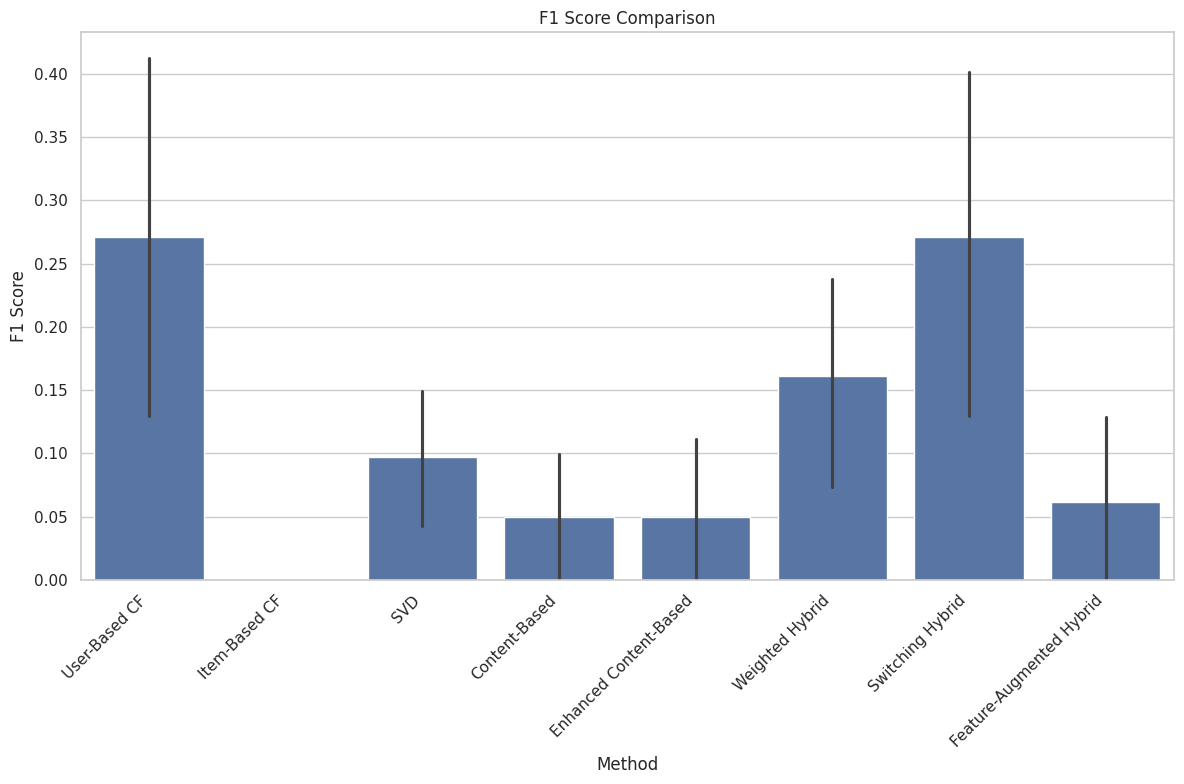

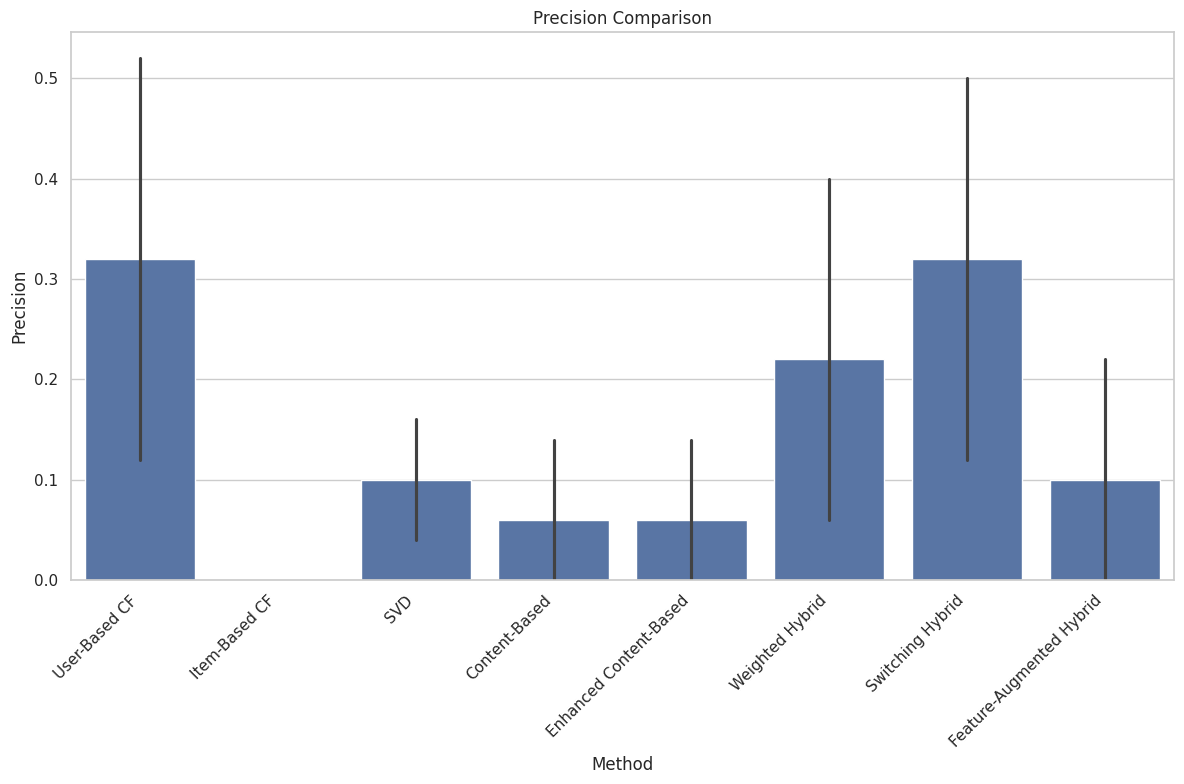

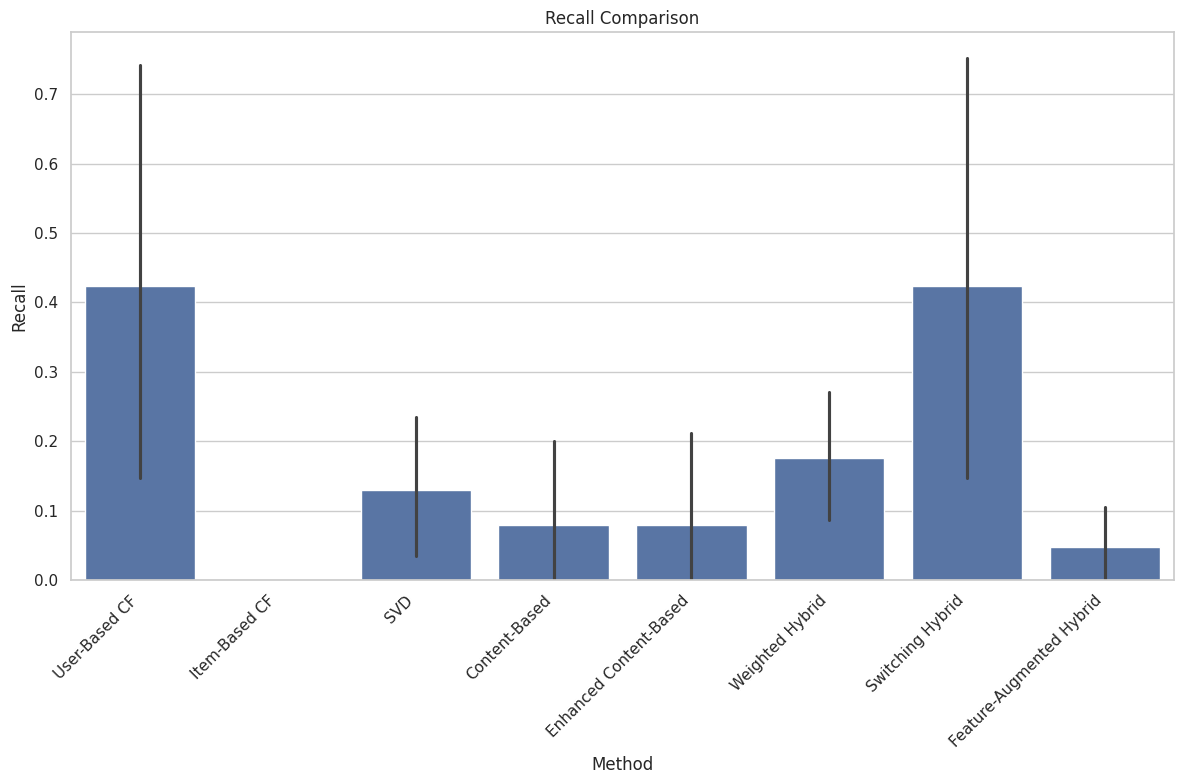

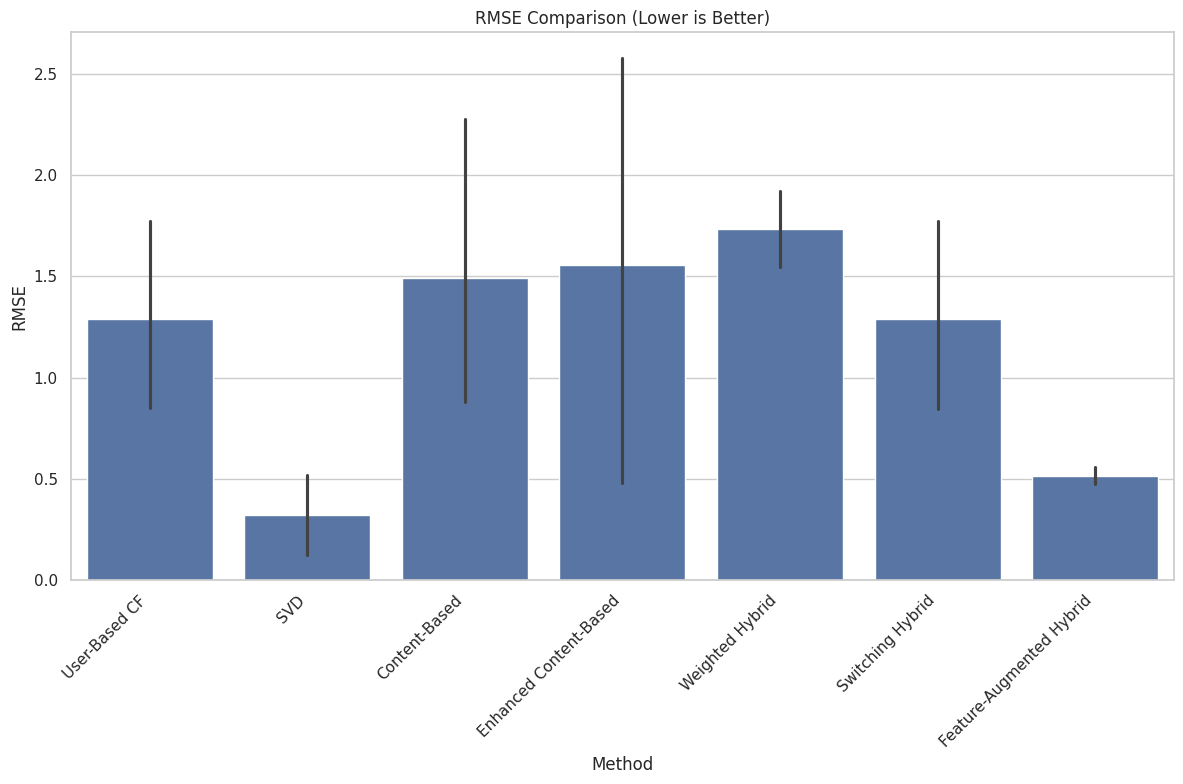

In [ ]:
def evaluate_all_methods(test_data, train_data, movies_df, svd_model, user_ids=None, n_recommendations=10):
    """
    Evaluate all recommendation methods for a set of users.

    Parameters:
    -----------
    test_data : pandas.DataFrame
        DataFrame containing test ratings
    train_data : pandas.DataFrame
        DataFrame containing training ratings
    movies_df : pandas.DataFrame
        DataFrame containing movie information
    svd_model : surprise.SVD
        Trained SVD model
    user_ids : list, optional
        List of user IDs to evaluate. If None, evaluates for all users in test set.
    n_recommendations : int, optional (default=10)
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing evaluation metrics for all methods and users
    """
    # If no user_ids provided, use all users in test set
    if user_ids is None:
        user_ids = test_data['user_id'].unique()

    # Limit to a reasonable number of users for demonstration
    if len(user_ids) > 10:
        user_ids = user_ids[:10]

    # Define recommendation methods to evaluate
    methods = {
        'User-Based CF': lambda user_id, train_data, movies_df: user_based_cf(train_data, movies_df, user_id, n_recommendations=n_recommendations),
        'Item-Based CF': lambda user_id, train_data, movies_df: item_based_cf(train_data, movies_df, user_id, n_recommendations=n_recommendations),
        'SVD': lambda user_id, train_data, movies_df: svd_recommendations(svd_model, train_data, movies_df, user_id, n_recommendations=n_recommendations),
        'Content-Based': lambda user_id, train_data, movies_df: content_based_filtering(movies_df, user_id, train_data, n_recommendations=n_recommendations),
        'Enhanced Content-Based': lambda user_id, train_data, movies_df: enhanced_content_based_filtering(movies_df, user_id, train_data, n_recommendations=n_recommendations),
        'Weighted Hybrid': lambda user_id, train_data, movies_df: weighted_hybrid_recommendations(user_id, train_data, movies_df, svd_model, n_recommendations=n_recommendations),
        'Switching Hybrid': lambda user_id, train_data, movies_df: switching_hybrid_recommendations(user_id, train_data, movies_df, svd_model, n_recommendations=n_recommendations),
        'Feature-Augmented Hybrid': lambda user_id, train_data, movies_df: feature_augmented_hybrid_recommendations(user_id, train_data, movies_df, svd_model, n_recommendations=n_recommendations)
    }

    # Evaluate each method for each user
    results = []
    for user_id in user_ids:
        for method_name, method_func in methods.items():
            print(f"Evaluating {method_name} for user {user_id}...")
            metrics = evaluate_recommendations(test_data, train_data, movies_df, user_id, method_func)

            if metrics is not None:
                metrics['user_id'] = user_id
                metrics['method'] = method_name
                results.append(metrics)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

# Evaluate all methods for a sample of users
sample_user_ids = [1, 2, 3, 4, 5]
evaluation_results = evaluate_all_methods(test_data, train_data, movies, svd, user_ids=sample_user_ids)

# Display average metrics per method
avg_metrics = evaluation_results.groupby('method')[['hit_rate', 'precision', 'recall', 'f1_score', 'rmse']].mean()
print("\nAverage Evaluation Metrics per Method:")
print(avg_metrics)

# Plot comparison of methods
plt.figure(figsize=(12, 8))
sns.barplot(x='method', y='f1_score', data=evaluation_results)
plt.title('F1 Score Comparison')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='method', y='precision', data=evaluation_results)
plt.title('Precision Comparison')
plt.xlabel('Method')
plt.ylabel('Precision')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='method', y='recall', data=evaluation_results)
plt.title('Recall Comparison')
plt.xlabel('Method')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot RMSE comparison (lower is better)
plt.figure(figsize=(12, 8))
rmse_data = evaluation_results.dropna(subset=['rmse'])  # Drop rows with NaN RMSE
sns.barplot(x='method', y='rmse', data=rmse_data)
plt.title('RMSE Comparison (Lower is Better)')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


6. Interactive Recommendation Interface


In [ ]:
from ipywidgets import widgets
from IPython.display import display, clear_output

# Function to display movie details
def display_movie_details(movie_id):
    movie = movies[movies['movie_id'] == movie_id].iloc[0]

    print(f"\nMovie ID: {movie_id}")
    print(f"Title: {movie['title']}")

    if pd.notna(movie['year']):
        print(f"Year: {int(movie['year'])}")

    # Get genres
    genre_cols = [col for col in movies.columns if col in ['Action', 'Adventure', 'Animation',
                                                         'Children\'s', 'Comedy', 'Crime',
                                                         'Documentary', 'Drama', 'Fantasy',
                                                         'Film-Noir', 'Horror', 'Musical',
                                                         'Mystery', 'Romance', 'Sci-Fi',
                                                         'Thriller', 'War', 'Western']]

    movie_genres = [genre for genre in genre_cols if movie[genre] == 1]
    print(f"Genres: {', '.join(movie_genres)}")

    # Get average rating
    avg_rating = ratings[ratings['movie_id'] == movie_id]['rating'].mean()
    num_ratings = len(ratings[ratings['movie_id'] == movie_id])
    print(f"Average Rating: {avg_rating:.2f} (from {num_ratings} ratings)")

    if pd.notna(movie['imdb_url']):
        print(f"IMDb URL: {movie['imdb_url']}")

# Function to get user ratings
def get_user_ratings():
    user_ratings = []

    # Get the most popular movies for rating
    popular_movies = movies.merge(
        ratings.groupby('movie_id')['rating'].count().reset_index().rename(columns={'rating': 'count'}),
        on='movie_id'
    ).sort_values('count', ascending=False).head(15)

    # Create a new user ID
    new_user_id = ratings['user_id'].max() + 1

    print("\nPlease rate some movies to get personalized recommendations.")
    print("Rate on a scale of 1-5, or enter 0 to skip a movie.\n")

    for _, row in popular_movies.iterrows():
        movie_id = row['movie_id']
        title = row['title']

        # Create a slider for rating
        rating_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=5,
            step=1,
            description=f"{title}:",
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

        display(rating_slider)

        # Store the rating
        if rating_slider.value > 0:
            user_ratings.append({
                'user_id': new_user_id,
                'movie_id': movie_id,
                'rating': rating_slider.value,
                'timestamp': int(time.time())
            })

    # Create a DataFrame with the new ratings
    user_ratings_df = pd.DataFrame(user_ratings)

    print(f"\nThank you! You've rated {len(user_ratings_df)} movies.")

    return new_user_id, user_ratings_df

# Function to show recommendations
def show_recommendations(algorithm, user_id=None, user_ratings_df=None):
    clear_output(wait=True)

    # Combine user ratings with training data
    if user_id is not None and len(user_ratings_df) > 0:
        combined_ratings = pd.concat([train_data, user_ratings_df])
    else:
        combined_ratings = train_data

    if algorithm == 'Popular':
        print("\nTop 10 Most Popular Movies:")
        popular_movies = movies.merge(
            ratings.groupby('movie_id')['rating'].count().reset_index().rename(columns={'rating': 'count'}),
            on='movie_id'
        ).sort_values('count', ascending=False).head(10)

        for i, (_, row) in enumerate(popular_movies.iterrows(), 1):
            avg_rating = ratings[ratings['movie_id'] == row['movie_id']]['rating'].mean()
            print(f"{i}. {row['title']} - {row['count']} ratings, Avg: {avg_rating:.2f}")

    elif algorithm == 'User-Based CF':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating recommendations based on similar users...")
        recommendations = user_based_cf(combined_ratings, movies, user_id)

        if len(recommendations) == 0:
            print("Sorry, we couldn't generate recommendations for you at this time.")
            return

        print("\nRecommended Movies Based on Similar Users:")
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} - Predicted Rating: {row['predicted_rating']:.2f}")

    elif algorithm == 'Item-Based CF':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating recommendations based on similar items...")
        recommendations = item_based_cf(combined_ratings, movies, user_id)

        if len(recommendations) == 0:
            print("Sorry, we couldn't generate recommendations for you at this time.")
            return

        print("\nRecommended Movies Based on Similar Items:")
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} - Predicted Rating: {row['predicted_rating']:.2f}")

    elif algorithm == 'Content-Based':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating recommendations based on movie content...")
        recommendations = content_based_filtering(movies, user_id, combined_ratings)

        if len(recommendations) == 0:
            print("Sorry, we couldn't generate recommendations for you at this time.")
            return

        print("\nRecommended Movies Based on Content:")
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} - Similarity: {row['similarity_score']:.2f}")

    elif algorithm == 'SVD':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating recommendations using matrix factorization...")

        # Retrain SVD with user's ratings
        reader = Reader(rating_scale=(1, 5))
        combined_data = Dataset.load_from_df(combined_ratings[['user_id', 'movie_id', 'rating']], reader)
        combined_trainset = combined_data.build_full_trainset()

        # Train SVD model
        user_svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
        user_svd.fit(combined_trainset)

        # Get recommendations
        recommendations = svd_recommendations(user_svd, combined_ratings, movies, user_id)

        print("\nRecommended Movies Based on Matrix Factorization:")
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} - Predicted Rating: {row['predicted_rating']:.2f}")

    elif algorithm == 'Weighted Hybrid':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating hybrid recommendations...")

        # Retrain SVD with user's ratings
        reader = Reader(rating_scale=(1, 5))
        combined_data = Dataset.load_from_df(combined_ratings[['user_id', 'movie_id', 'rating']], reader)
        combined_trainset = combined_data.build_full_trainset()

        # Train SVD model
        user_svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
        user_svd.fit(combined_trainset)

        # Get recommendations
        recommendations = weighted_hybrid_recommendations(
            user_id, combined_ratings, movies, user_svd
        )

        print("\nRecommended Movies Based on Weighted Hybrid Approach:")
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} - Score: {row['hybrid_score']:.2f}")

    elif algorithm == 'Switching Hybrid':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating hybrid recommendations...")

        # Retrain SVD with user's ratings
        reader = Reader(rating_scale=(1, 5))
        combined_data = Dataset.load_from_df(combined_ratings[['user_id', 'movie_id', 'rating']], reader)
        combined_trainset = combined_data.build_full_trainset()

        # Train SVD model
        user_svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
        user_svd.fit(combined_trainset)

        # Get recommendations
        recommendations = switching_hybrid_recommendations(
            user_id, combined_ratings, movies, user_svd
        )

        print("\nRecommended Movies Based on Switching Hybrid Approach:")
        if 'predicted_rating' in recommendations.columns:
            for i, (_, row) in enumerate(recommendations.iterrows(), 1):
                print(f"{i}. {row['title']} - Predicted Rating: {row['predicted_rating']:.2f}")
        elif 'similarity_score' in recommendations.columns:
            for i, (_, row) in enumerate(recommendations.iterrows(), 1):
                print(f"{i}. {row['title']} - Similarity: {row['similarity_score']:.2f}")

    elif algorithm == 'Feature-Augmented Hybrid':
        if user_id is None or len(user_ratings_df) == 0:
            print("You need to rate some movies first to get personalized recommendations.")
            return

        print("\nGenerating hybrid recommendations...")

        # Retrain SVD with user's ratings
        reader = Reader(rating_scale=(1, 5))
        combined_data = Dataset.load_from_df(combined_ratings[['user_id', 'movie_id', 'rating']], reader)
        combined_trainset = combined_data.build_full_trainset()

        # Train SVD model
        user_svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
        user_svd.fit(combined_trainset)

        # Get recommendations
        recommendations = feature_augmented_hybrid_recommendations(
            user_id, combined_ratings, movies, user_svd
        )

        print("\nRecommended Movies Based on Feature-Augmented Hybrid Approach:")
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} - Score: {row['augmented_score']:.2f}")

# Create interactive widgets
algorithm_dropdown = widgets.Dropdown(
    options=['Popular', 'User-Based CF', 'Item-Based CF', 'Content-Based', 'SVD',
             'Weighted Hybrid', 'Switching Hybrid', 'Feature-Augmented Hybrid'],
    value='Popular',
    description='Algorithm:',
    disabled=False,
)

rate_button = widgets.Button(
    description='Rate Movies',
    disabled=False,
    button_style='',
    tooltip='Click to rate movies',
    icon='star'
)

recommend_button = widgets.Button(
    description='Get Recommendations',
    disabled=False,
    button_style='',
    tooltip='Click to get recommendations',
    icon='check'
)

# Variables to store user ratings
user_id = None
user_ratings_df = pd.DataFrame()

# Define button click handlers
def on_rate_button_clicked(b):
    global user_id, user_ratings_df
    user_id, user_ratings_df = get_user_ratings()

def on_recommend_button_clicked(b):
    show_recommendations(algorithm_dropdown.value, user_id, user_ratings_df)

# Attach handlers to buttons
rate_button.on_click(on_rate_button_clicked)
recommend_button.on_click(on_recommend_button_clicked)

# Display widgets
print("Welcome to the Hybrid Movie Recommendation System!")
print("Please select an algorithm and either rate movies or get recommendations.")
display(algorithm_dropdown)
display(rate_button)
display(recommend_button)



Top 10 Most Popular Movies:
1. Star Wars - 583 ratings, Avg: 4.36
2. Contact - 509 ratings, Avg: 3.80
3. Fargo - 508 ratings, Avg: 4.16
4. Return of the Jedi - 507 ratings, Avg: 4.01
5. Liar Liar - 485 ratings, Avg: 3.16
6. English Patient, The - 481 ratings, Avg: 3.66
7. Scream - 478 ratings, Avg: 3.44
8. Toy Story - 452 ratings, Avg: 3.88
9. Air Force One - 431 ratings, Avg: 3.63
10. Independence Day (ID4) - 429 ratings, Avg: 3.44


In [ ]:
# ⏩ Colab cell: install & imports
!pip install gradio tmdbv3api scikit-surprise

import os, pickle
import pandas as pd
import numpy as np
from tmdbv3api import TMDb, Movie
import gradio as gr
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD

# 1) Load & prep
ratings = pd.read_csv('data/train_data.csv')         # your train split
movies  = pd.read_csv('data/processed_movies.csv')   # your processed movies

# Detect genre columns (0/1 flags) and zero-fill any NaNs
genre_cols = [c for c in movies.columns
              if set(movies[c].dropna().unique()) <= {0,1}
              and c not in ['movie_id']]
movies[genre_cols] = movies[genre_cols].fillna(0)

# 2) Train SVD
reader   = Reader(rating_scale=(1,5))
dsur     = Dataset.load_from_df(ratings[['user_id','movie_id','rating']], reader)
trainset = dsur.build_full_trainset()
svd      = SVD(n_factors=50, n_epochs=15, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)

# 3) Content-based similarity
genre_sim = cosine_similarity(movies[genre_cols].values)

# 4) TMDb posters + cache
TMDB_API_KEY = "82e3b7280350b7f68a04ac084dfebe80"
tmdb     = TMDb(); tmdb.api_key = TMDB_API_KEY; tmdb.language = 'en'
movie_api= Movie()
CACHE_F  = 'tmdb_posters.pkl'
poster_cache = pickle.load(open(CACHE_F,'rb')) if os.path.exists(CACHE_F) else {}

def fetch_poster_url(title, year, ml_id):
    ml_id = int(ml_id)
    try:    year = int(year)
    except: year = 0
    if ml_id in poster_cache:
        return poster_cache[ml_id]
    results = list(movie_api.search(f"{title} {year}"))
    if results and getattr(results[0],'poster_path',None):
        url = f"https://image.tmdb.org/t/p/w300{results[0].poster_path}"  # Changed to w300 for better quality
    else:
        url = None
    poster_cache[ml_id] = url
    return url

# Pre-fetch all posters (~2min for 1.6k titles)
print("Fetching movie posters...")
for i, (_, r) in enumerate(movies.iterrows()):
    if i % 100 == 0:
        print(f"Processed {i}/{len(movies)} movies")
    fetch_poster_url(r.title, r.year, r.movie_id)
pickle.dump(poster_cache, open(CACHE_F,'wb'))
print("Poster fetching completed!")

# Random placeholder images for missing posters
PLACEHOLDER_IMAGES = [
    "https://via.placeholder.com/300x450/FF6B6B/FFFFFF?text=🎬+Movie",
    "https://via.placeholder.com/300x450/4ECDC4/FFFFFF?text=🎭+Cinema",
    "https://via.placeholder.com/300x450/45B7D1/FFFFFF?text=🍿+Film",
    "https://via.placeholder.com/300x450/96CEB4/FFFFFF?text=🎪+Picture",
    "https://via.placeholder.com/300x450/FFEAA7/333333?text=🎯+Movie",
    "https://via.placeholder.com/300x450/DDA0DD/FFFFFF?text=🌟+Cinema",
    "https://via.placeholder.com/300x450/98D8C8/FFFFFF?text=🎨+Film",
    "https://via.placeholder.com/300x450/F7DC6F/333333?text=🎵+Picture"
]

import random
def get_random_placeholder():
    return random.choice(PLACEHOLDER_IMAGES)

# 5) Helper: DataFrame → Gallery list with random placeholders
def df_to_gallery_list(df):
    df = df.copy()
    gallery_list = []
    for _, row in df.iterrows():
        poster_url = poster_cache.get(row.movie_id)
        if not poster_url:
            poster_url = get_random_placeholder()
        gallery_list.append((poster_url, f"{row.title} ({int(row.year) if pd.notnull(row.year) else 'N/A'})"))
    return gallery_list

# 6) Recommendation engines
def content_recs(user_id, n=10):
    ur = ratings[ratings.user_id==user_id]
    if len(ur) == 0:
        return pd.DataFrame(columns=['movie_id', 'score', 'title'])
    top = ur[ur.rating>=4]['movie_id'].tolist() or ur.movie_id.tolist()
    rated = set(ur.movie_id)
    scores = []
    for mid in movies.movie_id:
        if mid in rated: continue
        try:
            i = movies.index[movies.movie_id==mid][0]
            sim = sum(genre_sim[i, movies.index[movies.movie_id==t][0]] for t in top)/len(top)
            scores.append((mid, sim))
        except:
            continue
    scores.sort(key=lambda x: x[1], reverse=True)
    return pd.DataFrame(scores[:n], columns=['movie_id','score']) \
             .merge(movies[['movie_id','title','year']], on='movie_id')

def svd_recs(user_id, n=10):
    urated = set(ratings[ratings.user_id==user_id].movie_id)
    preds  = [(mid, svd.predict(user_id,mid).est)
              for mid in movies.movie_id if mid not in urated]
    preds.sort(key=lambda x: x[1], reverse=True)
    return pd.DataFrame(preds[:n], columns=['movie_id','est']) \
             .merge(movies[['movie_id','title','year']], on='movie_id')

def hybrid_recs(user_id, n=10):
    cf = content_recs(user_id, n*2)
    sv = svd_recs    (user_id, n*2)
    if len(cf) == 0 and len(sv) == 0:
        return pd.DataFrame(columns=['movie_id', 'score', 'title', 'year'])
    cf_d = dict(zip(cf.movie_id, cf.score)) if len(cf) > 0 else {}
    sv_d = dict(zip(sv.movie_id, sv.est)) if len(sv) > 0 else {}
    allm = set(cf_d)|set(sv_d)
    hy  = []
    for mid in allm:
        c = cf_d.get(mid,0)
        s = sv_d.get(mid,0)
        hy.append((mid, 0.5*c + 0.5*(s-1)/4))
    hy.sort(key=lambda x:x[1], reverse=True)
    return pd.DataFrame(hy[:n], columns=['movie_id','score']) \
             .merge(movies[['movie_id','title','year']], on='movie_id')

# 7) User stats functions
def get_user_stats(user_id):
    ur = ratings[ratings.user_id == user_id]
    if len(ur) == 0:
        return "No ratings found for this user."

    stats = f"""
    ### 📊 Your Rating Statistics

    **Total Movies Rated:** {len(ur)}
    **Average Rating:** {ur.rating.mean():.2f}/5.0
    **Rating Distribution:**
    - ⭐ 1 star: {len(ur[ur.rating==1])} movies
    - ⭐⭐ 2 stars: {len(ur[ur.rating==2])} movies
    - ⭐⭐⭐ 3 stars: {len(ur[ur.rating==3])} movies
    - ⭐⭐⭐⭐ 4 stars: {len(ur[ur.rating==4])} movies
    - ⭐⭐⭐⭐⭐ 5 stars: {len(ur[ur.rating==5])} movies

    **Most Common Rating:** {ur.rating.mode().iloc[0]} stars
    """
    return stats

def get_user_ratings(user_id):
    ur = ratings[ratings.user_id == user_id]
    if len(ur) == 0:
        return []

    user_movies = ur.merge(movies[['movie_id', 'title', 'year']], on='movie_id')
    user_movies = user_movies.sort_values('rating', ascending=False)

    return df_to_gallery_list(user_movies)

# 8) Build Gradio UI
with gr.Blocks(css="""
#login_box {max-width:400px; margin:auto; padding:30px; border:2px solid #ddd; border-radius:15px; background: #f9f9f9;}
#main_box  {margin:20px;}
.gallery-container img {border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);}
""") as app:

    gr.Markdown("# 🎬 MovieLens Hybrid Recommender System")
    current_user = gr.State(None)

    # — LOGIN —
    login_box = gr.Column(elem_id="login_box", visible=True)
    with login_box:
        gr.Markdown("## 🔑 Please Login to Continue")
        user_dd  = gr.Dropdown(sorted(ratings.user_id.unique()), label="Select Your User ID")
        login_bt = gr.Button("🚀 Login", variant="primary", size="lg")
        login_msg= gr.Markdown("Please select a user ID and click **Login** to access the recommender system.")

    # — MAIN APP (hidden until login) —
    main_box = gr.Column(elem_id="main_box", visible=False)
    with main_box:
        # Header with welcome and logout
        with gr.Row():
            welcome = gr.Markdown()
            logout_bt = gr.Button("🚪 Logout", variant="secondary", size="sm")

        with gr.Tabs():

            # — HOME TAB —
            with gr.TabItem("🏠 Home"):
                with gr.Row():
                    with gr.Column(scale=3):
                        search = gr.Textbox(placeholder="🔍 Search movies by title...", show_label=False)
                    with gr.Column(scale=1):
                        genre_filter = gr.Dropdown(["All"] + genre_cols, value="All", label="Filter by Genre")

                all_movies = movies.copy()
                gallery_all = gr.Gallery(
                    value=df_to_gallery_list(all_movies),
                    columns=5, show_label=False, height=600
                )

                with gr.Row():
                    with gr.Column(scale=2):
                        details = gr.Markdown("👈 Click on a movie poster to see details and recommendations!")
                    with gr.Column(scale=1):
                        more_like = gr.Gallery(columns=2, show_label=False, height=400)

                # Search and filter logic
                def filter_movies(search_query, genre_filter):
                    df = all_movies.copy()

                    if search_query.strip():
                        df = df[df.title.str.contains(search_query, case=False, na=False)]

                    if genre_filter != "All":
                        df = df[df[genre_filter] == 1]

                    return df_to_gallery_list(df)

                search.submit(filter_movies, inputs=[search, genre_filter], outputs=gallery_all)
                genre_filter.change(filter_movies, inputs=[search, genre_filter], outputs=gallery_all)

                # Show details + hybrid recs - FIXED VERSION
                def show_details(evt: gr.SelectData, uid):
                    if uid is None:
                        return ("🔒 Please login first!", [])

                    try:
                        # Handle both string and dict cases for evt.value
                        if isinstance(evt.value, dict):
                            # If it's a dict, try to get the caption or other text field
                            selected_item = evt.value.get('caption', '') or evt.value.get('text', '') or str(evt.value)
                        else:
                            selected_item = str(evt.value)

                        # Extract title from the format "Title (Year)"
                        if " (" in selected_item:
                            title_with_year = selected_item.split(" (")[0]
                        else:
                            title_with_year = selected_item

                        # Handle empty title
                        if not title_with_year.strip():
                            return ("Could not extract movie title!", [])

                        # Find the movie - use exact match first, then partial match
                        rw = movies[movies.title == title_with_year]
                        if len(rw) == 0:
                            # Try partial match if exact match fails
                            rw = movies[movies.title.str.contains(str(title_with_year), case=False, na=False)]

                        if len(rw) == 0:
                            return (f"Movie '{title_with_year}' not found in database!", [])

                        rw = rw.iloc[0]
                        txt = f"### 🎬 {rw.title} ({int(rw.year) if pd.notnull(rw.year) else 'N/A'})\n\n"

                        if 'release_date' in rw and pd.notnull(rw.release_date):
                            txt += f"**📅 Release Date:** {rw.release_date}\n\n"

                        genres = [g.replace('_', ' ').title() for g in genre_cols if rw[g]==1]
                        if genres:
                            txt += f"**🎭 Genres:** {', '.join(genres)}\n\n"

                        txt += "**🤖 Movies You Might Like:**"

                        recs = hybrid_recs(uid, n=6)
                        return txt, df_to_gallery_list(recs)

                    except Exception as e:
                        return (f"Error processing selection: {str(e)}", [])

                gallery_all.select(show_details, inputs=current_user, outputs=[details, more_like])

            # — BROWSE BY GENRE TAB —
            with gr.TabItem("🎭 Browse by Genre"):
                genre_dd = gr.Dropdown(genre_cols, label="Select Genre")
                genre_gal = gr.Gallery(columns=5, show_label=False, height=600)

                def by_genre(g):
                    if not g:
                        return []
                    df = movies[movies[g]==1].copy()
                    return df_to_gallery_list(df)

                genre_dd.change(by_genre, inputs=genre_dd, outputs=genre_gal)

            # — POPULAR MOVIES TAB —
            with gr.TabItem("🔥 Popular Movies"):
                gr.Markdown("### 🌟 Highest Rated Movies")

                # Calculate popular movies
                movie_stats = ratings.groupby('movie_id').agg({
                    'rating': ['mean', 'count']
                }).round(2)
                movie_stats.columns = ['avg_rating', 'num_ratings']
                movie_stats = movie_stats.reset_index()

                # Filter movies with at least 20 ratings and sort by average rating
                popular_movies = movie_stats[movie_stats.num_ratings >= 20].sort_values('avg_rating', ascending=False)
                top_movies = popular_movies.head(24)

                pop_df = movies[movies.movie_id.isin(top_movies.movie_id)].copy()
                pop_df = pop_df.merge(top_movies, on='movie_id')
                pop_df = pop_df.sort_values('avg_rating', ascending=False)

                gr.Gallery(
                    value=df_to_gallery_list(pop_df),
                    columns=6, show_label=False, height=600
                )

            # — YOUR RECOMMENDATIONS TAB —
            with gr.TabItem("🎯 Your Recommendations"):
                rec_type = gr.Radio(
                    ["Hybrid", "Content-Based", "Collaborative Filtering"],
                    value="Hybrid",
                    label="Recommendation Method"
                )
                rec_gallery = gr.Gallery(columns=5, show_label=False, height=600)
                rec_info = gr.Markdown()

                def get_recommendations(rec_type, uid):
                    if uid is None:
                        return [], "🔒 Please login to see recommendations!"

                    if rec_type == "Hybrid":
                        recs = hybrid_recs(uid, n=20)
                        info = "🔀 **Hybrid Recommendations** - Combines content similarity and collaborative filtering"
                    elif rec_type == "Content-Based":
                        recs = content_recs(uid, n=20)
                        info = "🎭 **Content-Based Recommendations** - Based on genres of movies you liked"
                    else:  # Collaborative Filtering
                        recs = svd_recs(uid, n=20)
                        info = "👥 **Collaborative Filtering** - Based on users with similar taste"

                    if len(recs) == 0:
                        return [], f"{info}\n\n❌ No recommendations available. Try rating more movies!"

                    return df_to_gallery_list(recs), f"{info}\n\n✅ Found {len(recs)} recommendations for you!"

                rec_type.change(get_recommendations, inputs=[rec_type, current_user], outputs=[rec_gallery, rec_info])

            # — YOUR RATINGS TAB —
            with gr.TabItem("⭐ Your Ratings"):
                with gr.Row():
                    with gr.Column(scale=1):
                        rating_stats = gr.Markdown()
                    with gr.Column(scale=2):
                        rating_gallery = gr.Gallery(columns=4, show_label=False, height=600)

                def load_user_data(uid):
                    if uid is None:
                        return "🔒 Please login to see your ratings!", []

                    stats = get_user_stats(uid)
                    ratings_list = get_user_ratings(uid)
                    return stats, ratings_list

    # — LOGIN/LOGOUT CALLBACKS —
    def do_login(uid):
        if uid is None:
            return None, "❌ Please select a user ID!", gr.update(visible=True), gr.update(visible=False), "", [], "🔒 Please login to see recommendations!", "", []

        # Load initial data for user
        recs = hybrid_recs(uid, n=20)
        rec_gallery_data = df_to_gallery_list(recs)
        rec_info_text = f"🔀 **Hybrid Recommendations** - Combines content similarity and collaborative filtering\n\n✅ Found {len(recs)} recommendations for you!"

        stats = get_user_stats(uid)
        ratings_list = get_user_ratings(uid)

        return (
            uid,
            f"✅ Successfully logged in!",
            gr.update(visible=False),
            gr.update(visible=True),
            f"### 👋 Welcome, **User {uid}**! Explore movies and get personalized recommendations.",
            rec_gallery_data,
            rec_info_text,
            stats,
            ratings_list
        )

    def do_logout():
        return (
            None,
            "Please select a user ID and click **Login** to access the recommender system.",
            gr.update(visible=True),
            gr.update(visible=False),
            "",
            [],
            "🔒 Please login to see recommendations!",
            "",
            []
        )

    login_bt.click(
        do_login,
        inputs=user_dd,
        outputs=[current_user, login_msg, login_box, main_box, welcome, rec_gallery, rec_info, rating_stats, rating_gallery]
    )

    logout_bt.click(
        do_logout,
        outputs=[current_user, login_msg, login_box, main_box, welcome, rec_gallery, rec_info, rating_stats, rating_gallery]
    )

# Launch the app
app.launch(share=True, debug=True)

Fetching movie posters...
Processed 0/1682 movies
Processed 100/1682 movies
Processed 200/1682 movies
Processed 300/1682 movies
Processed 400/1682 movies
Processed 500/1682 movies
Processed 600/1682 movies
Processed 700/1682 movies
Processed 800/1682 movies
Processed 900/1682 movies
Processed 1000/1682 movies
Processed 1100/1682 movies
Processed 1200/1682 movies
Processed 1300/1682 movies
Processed 1400/1682 movies
Processed 1500/1682 movies
Processed 1600/1682 movies
Poster fetching completed!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3726350ac3afdda227.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7866 <> https://3726350ac3afdda227.gradio.live
